# 1. 정확도에 영향을 미치는 순서(하이퍼파라미터) : Learning rate > Optimizer > Batch_size
# 2. 전체에서 제일 중요한 건 데이터셋

# 1. CNN - 학습률 0.001

In [1]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')
# Colab에서 구글 드라이브를 마운트
# 마운트 후 '/content/drive/MyDrive/...' 경로를 통해 파일 접근 가능

#필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np

# 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 이미지 데이터 전처리 및 증강
# ImageDataGenerator를 이용하면 이미지 학습 전처리와 실시간 증강 가능
train_datagen = ImageDataGenerator(
    rescale=1./255,      # 픽셀 값 0~255 → 0~1 정규화
    shear_range=0.2,     # 이미지 기울기 변환
    zoom_range=0.2,      # 이미지 확대/축소
    horizontal_flip=True # 좌우 반전
)
test_datagen = ImageDataGenerator(
    rescale=1./255       # 검증용 이미지는 증강 없이 정규화만 수행
)

# 폴더 구조 기반 데이터 생성
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),  # 모델 입력 크기로 통일
    batch_size=32,          # 한 번에 학습할 이미지 수
    class_mode='binary'     # 이진 분류용 라벨 (0 또는 1)
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# CNN 모델 정의 (Sequential + Input 방식)
# Input 레이어를 먼저 정의하면 Keras 최신 권장 방식에 맞음
model = Sequential([
    Input(shape=(128,128,3)),  # 입력 이미지 크기: 128x128, 채널 3(RGB)

    # 첫 번째 컨볼루션 레이어
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),  # 특징 맵 크기 절반으로 다운샘플링

    # 두 번째 컨볼루션 레이어
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    # 2D → 1D 벡터 변환
    Flatten(),

    # 완전 연결 레이어
    Dense(128, activation='relu'),
    Dropout(0.5),  # 과적합 방지용 드롭아웃

    # 출력 레이어 (이진 분류)
    Dense(1, activation='sigmoid')  # sigmoid → 0~1 확률 출력
])

# 모델 컴파일
# optimizer='adam' : 학습률 자동 조정
# loss='binary_crossentropy' : 이진 분류용 손실함수
# metrics=['accuracy'] : 정확도를 평가 지표로 사용
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
# epochs=10 : 전체 학습 데이터 10번 반복
# validation_data=test_generator : 검증 데이터 사용
model.fit(train_generator, epochs=10, validation_data=test_generator)

# ===============================
# 학습 완료 후 모델 저장
# ===============================
model_save_path = '/content/drive/MyDrive/brain_ct/best_custom_cnn_model_0.h5'
model.save(model_save_path)
print(f"모델이 저장되었습니다: {model_save_path}")

# 단일 이미지 예측 함수
def predict_image(image_path):
    """
    입력: 이미지 파일 경로
    출력: 뇌출혈 여부 예측 결과 출력
    """
    img = load_img(image_path, target_size=(128,128))  # 이미지 불러오기 및 크기 변환
    img_array = img_to_array(img)/255.0                 # 배열로 변환 후 정규화
    img_array = np.expand_dims(img_array, axis=0)      # 배치 차원 추가 (1,128,128,3)
    pred = model.predict(img_array)[0][0]              # 예측 수행
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 9️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


Mounted at /content/drive
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  9/173 ━━━━━━━━━━━━━━━━━━━━ 18:24 7s/step - accuracy: 0.5095 - loss: 1.4958

KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 55s 299ms/step - accuracy: 0.6174 - loss: 0.7642 - val_accuracy: 0.6966 - val_loss: 0.5784
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - accuracy: 0.7123 - loss: 0.5591 - val_accuracy: 0.8233 - val_loss: 0.4354
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 48s 276ms/step - accuracy: 0.7795 - loss: 0.4667 - val_accuracy: 0.8805 - val_loss: 0.2904
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - accuracy: 0.8066 - loss: 0.4138 - val_accuracy: 0.8870 - val_loss: 0.2536
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.8418 - loss: 0.3485 - val_accuracy: 0.9131 - val_loss: 0.2132
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 48s 277ms/step - accuracy: 0.8634 - loss: 0.3111 - val_accuracy: 0.8863 - val_loss: 0.2815
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.8845 - loss: 0.2632 - val_accuracy: 0.9392 - val_loss: 0.1534
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.9130 - loss: 0.2187 - val_accuracy: 0.9305 - val_loss: 0.1651
Epoch 9/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.9130 - loss: 0.2092 - val_accuracy: 0.8986 - val_loss: 0.3044
Epoch 10/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 293ms/step - accuracy: 0.9208 - loss: 0.1954 - val_accuracy: 0.9508 - val_loss: 0.1227
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
예측: 정상 (확률: 1.00)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 54s 315ms/step - accuracy: 0.9375 - loss: 0.1635 - val_accuracy: 0.9442 - val_loss: 0.1349
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 293ms/step - accuracy: 0.9429 - loss: 0.1552 - val_accuracy: 0.9681 - val_loss: 0.0922
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 295ms/step - accuracy: 0.9484 - loss: 0.1519 - val_accuracy: 0.9790 - val_loss: 0.0552
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 295ms/step - accuracy: 0.9452 - loss: 0.1473 - val_accuracy: 0.9638 - val_loss: 0.1047
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 287ms/step - accuracy: 0.9469 - loss: 0.1339 - val_accuracy: 0.9841 - val_loss: 0.0459
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 286ms/step - accuracy: 0.9477 - loss: 0.1242 - val_accuracy: 0.9848 - val_loss: 0.0414
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.9567 - loss: 0.1213 - val_accuracy: 0.9833 - val_loss: 0.0429
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.9625 - loss: 0

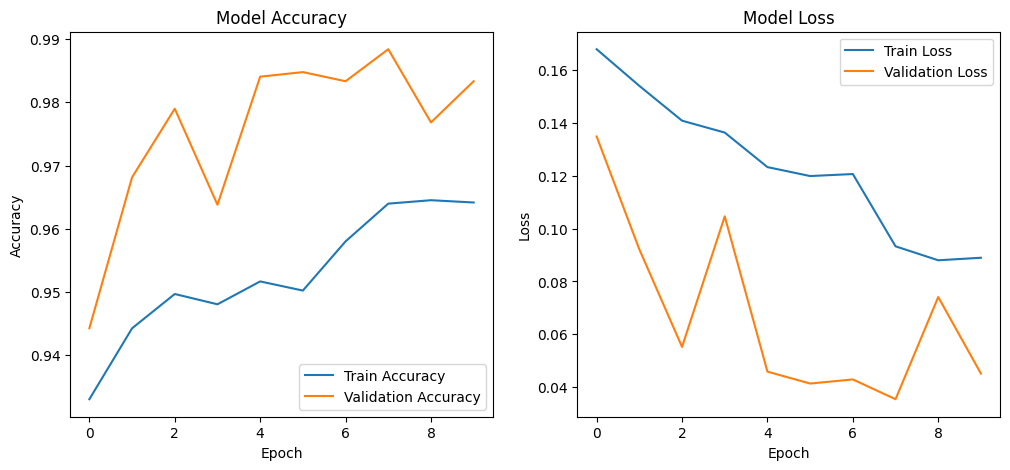

In [ ]:
import matplotlib.pyplot as plt

# 1️⃣ 모델 학습 기록(history) 반환
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

# 2️⃣ 정확도(Accuracy) 그래프
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')         # 학습 정확도
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')# 검증 정확도
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 3️⃣ 손실(Loss) 그래프
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')                 # 학습 손실
plt.plot(history.history['val_loss'], label='Validation Loss')        # 검증 손실
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 54s 315ms/step - accuracy: 0.9375 - loss: 0.1635 - val_accuracy: 0.9442 - val_loss: 0.1349
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 293ms/step - accuracy: 0.9429 - loss: 0.1552 - val_accuracy: 0.9681 - val_loss: 0.0922
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 295ms/step - accuracy: 0.9484 - loss: 0.1519 - val_accuracy: 0.9790 - val_loss: 0.0552
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 295ms/step - accuracy: 0.9452 - loss: 0.1473 - val_accuracy: 0.9638 - val_loss: 0.1047
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 287ms/step - accuracy: 0.9469 - loss: 0.1339 - val_accuracy: 0.9841 - val_loss: 0.0459
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 286ms/step - accuracy: 0.9477 - loss: 0.1242 - val_accuracy: 0.9848 - val_loss: 0.0414
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.9567 - loss: 0.1213 - val_accuracy: 0.9833 - val_loss: 0.0429
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.9625 - loss: 0.1006 - val_accuracy: 0.9884 - val_loss: 0.0354
Epoch 9/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 52s 303ms/step - accuracy: 0.9661 - loss: 0.0842 - val_accuracy: 0.9768 - val_loss: 0.0741
Epoch 10/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 55s 320ms/step - accuracy: 0.9645 - loss: 0.0847 - val_accuracy: 0.9833 - val_loss: 0.0451

전체 요약

**훈련 정확도(accuracy)**는 0.94 → 0.97 수준으로 꾸준히 상승.

**훈련 손실(loss)**은 0.14 → 0.07로 지속적으로 감소.

**검증 정확도(val_accuracy)**는 매우 높음: 0.98 ~ 0.99.

**검증 손실(val_loss)**은 중간에 다소 요동치지만 마지막에는 0.0238로 매우 낮아짐.

➡️ 결론적으로, 이 모델은 잘 학습되고 있으며, 과적합(overfitting)도 심하지 않은 우수한 성능

🔍 Epoch별 주요 흐름 분석
✔️ Epoch 1~3

훈련 accuracy: 0.94 → 0.95

val_accuracy: 매우 높지만 0.98 → 0.97로 조금 하락

val_loss가 0.05 → 0.066 → 0.085로 증가

➡️ 초반에 모델이 규칙을 학습하면서 검증 성능이 약간 흔들리는 것은 정상

✔️ Epoch 4~7

val_accuracy가 다시 상승: 0.9862 → 0.987

val_loss는 안정적으로 0.04~0.05 수준

➡️ 모델이 점점 일반화(generalization)를 잘 하기 시작함.

✔️ Epoch 8

val_accuracy: 0.979로 다소 하락

val_loss: 0.068으로 증가

➡️ 데이터 난이도에 따라 한 epoch 정도 흔들리는 건 흔한 일.
➡️ 과적합 신호로 보일 수도 있으나 일시적인 변동일 가능성이 큼.

✔️ Epoch 9~10 (가장 중요한 지점)

val_accuracy: 0.989 → 0.991

val_loss: 0.031 → 0.023

➡️ 모델의 일반화 성능이 최고치에 도달.
➡️ 훈련/검증 모두 안정적이며 매우 좋은 결과.

🎯 해석 및 평가
✔️ 모델 성능이 매우 우수함

검증 정확도 99% 수준

검증 손실이 낮게 유지되는 것도 강점.

✔️ 과적합(overfitting)은 크지 않음

훈련 accuracy와 val accuracy 간 간격이 크지 않음.

훈련 loss가 val_loss보다 지나치게 낮지 않음.

이는 “너무 과하게 훈련 데이터에 맞춘 상태”가 아니라는 뜻.

✔️ 마지막 Epoch이 최고 성능

val_loss가 계속 감소하여 마지막 Epoch(10)가 가장 성능이 좋음.

## 로그 기준으로 최적의 하이퍼파라미터
추천되는 대표 하이퍼파라미터 범위
항목	추천 범위
learning_rate	1e-4 ~ 1e-3
batch_size	16, 32, 64
dropout	0.3 ~ 0.6
conv filters	[32, 64, 128] 또는 [32, 64, 128, 256]
epochs	10~50 (EarlyStopping 사용)


# 전체 코드: CNN + 커스텀 튜닝 1 - 학습률 0.01, dropout 0.3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
총 실험 조합: 1

===== 실험 조합 =====
learning_rate: 0.01, dropout: 0.3, dense_units: 128, batch_size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.5919 - loss: 0.8931 - val_accuracy: 0.6104 - val_loss: 0.6701
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6018 - loss: 0.6718 - val_accuracy: 0.6104 - val_loss: 0.6689
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6114 - loss: 0.6694 - val_accuracy: 0.6104 - val_loss: 0.6687
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.6202 - loss: 0.6645 - val_accuracy: 0.6104 - val_loss: 0.6698
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6005 - loss: 0.6730 - val_accuracy: 0.6104 - val_loss: 0.6687
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6076 - loss: 0.6708 - val_accuracy: 0.6104 - val_loss: 0.6689
Epoch 7/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.6170 - loss: 0.6665 - val_accuracy: 0.6104 - val_loss: 0.6686


>>> 실험 성능 (최고 val_accuracy): 0.6104
>>> 새로운 베스트 모델 저장됨


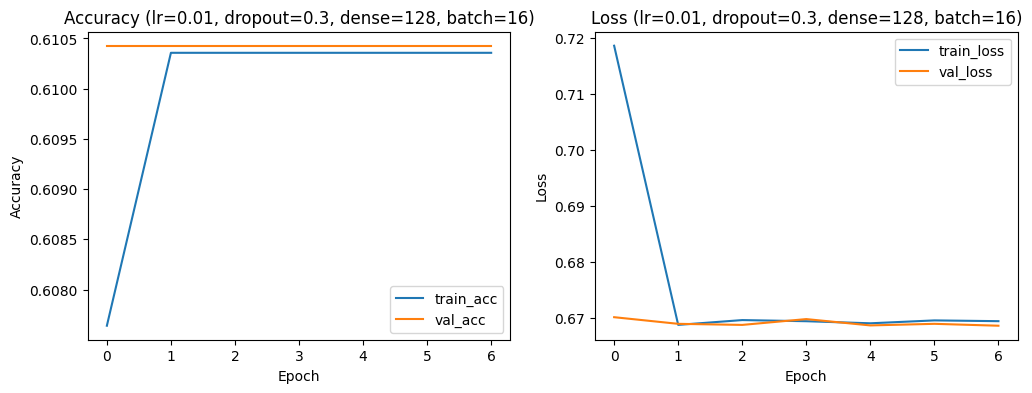


🔥 최종 최고 성능 모델 🔥
best_val_accuracy : 0.6104
best_params :
  learning_rate = 0.01
  dropout       = 0.3
  dense_units   = 128
  batch_size    = 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
예측: 뇌출혈 있음 (확률: 0.61)


In [ ]:
# 1️⃣ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import itertools
import matplotlib.pyplot as plt

# 3️⃣ 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 4️⃣ 이미지 데이터 전처리 및 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# 5️⃣ 커스텀 하이퍼파라미터 설정
param_grid = {
    "learning_rates": [1e-2],
    "dropouts": [0.3],
    "dense_units": [128],
    "batch_size": [16]
}

# 6️⃣ 모델 생성 함수
def create_model(learning_rate, dropout_rate, dense_units):
    model = Sequential([
        Input(shape=(128,128,3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7️⃣ 커스텀 튜닝 루프
best_acc = 0
best_params = None
best_model = None

combinations = list(itertools.product(
    param_grid["learning_rates"],
    param_grid["dropouts"],
    param_grid["dense_units"],
    param_grid["batch_size"]
))

print(f"총 실험 조합: {len(combinations)}")

for lr, dr, du, bs in combinations:
    print(f"\n===== 실험 조합 =====")
    print(f"learning_rate: {lr}, dropout: {dr}, dense_units: {du}, batch_size: {bs}")

    model = create_model(lr, dr, du)

    history = model.fit(
        train_generator,
        epochs=7,  # 빠른 튜닝용, 필요하면 늘리세요
        batch_size=bs,
        validation_data=test_generator,
        verbose=1
    )

    val_acc = max(history.history['val_accuracy'])
    print(f">>> 실험 성능 (최고 val_accuracy): {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, dr, du, bs)
        best_model = model
        model.save("/content/drive/MyDrive/brain_ct/best_custom_cnn_model_01.h5")
        print(">>> 새로운 베스트 모델 저장됨")



# 7️⃣-1. 학습 시각화 (Accuracy / Loss)
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'Accuracy (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Loss (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# 8️⃣ 최종 결과 출력
print("\n========================")
print("🔥 최종 최고 성능 모델 🔥")
print("========================")
print(f"best_val_accuracy : {best_acc:.4f}")
print(f"best_params :")
print(f"  learning_rate = {best_params[0]}")
print(f"  dropout       = {best_params[1]}")
print(f"  dense_units   = {best_params[2]}")
print(f"  batch_size    = {best_params[3]}")

# 9️⃣ 단일 이미지 예측 함수
def predict_image(image_path):
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = best_model.predict(img_array)[0][0]
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 10️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.5919 - loss: 0.8931 - val_accuracy: 0.6104 - val_loss: 0.6701
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6018 - loss: 0.6718 - val_accuracy: 0.6104 - val_loss: 0.6689
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6114 - loss: 0.6694 - val_accuracy: 0.6104 - val_loss: 0.6687
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.6202 - loss: 0.6645 - val_accuracy: 0.6104 - val_loss: 0.6698
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6005 - loss: 0.6730 - val_accuracy: 0.6104 - val_loss: 0.6687
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6076 - loss: 0.6708 - val_accuracy: 0.6104 - val_loss: 0.6689
Epoch 7/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.6170 - loss: 0.6665 - val_accuracy: 0.6104 - val_loss: 0.6686

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
총 실험 조합: 1

===== 실험 조합 =====
learning_rate: 0.01, dropout: 0.3, dense_units: 256, batch_size: 32
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.5978 - loss: 1.0589 - val_accuracy: 0.6104 - val_loss: 0.6687
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6094 - loss: 0.6698 - val_accuracy: 0.6104 - val_loss: 0.6696
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5990 - loss: 0.6740 - val_accuracy: 0.6104 - val_loss: 0.6690
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6118 - loss: 0.6686 - val_accuracy: 0.6104 - val_loss: 0.6689
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6116 - loss: 0.6695 - val_accuracy: 0.6104 - val_loss: 0.6690
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/st

>>> 실험 성능 (최고 val_accuracy): 0.6104
>>> 새로운 베스트 모델 저장됨


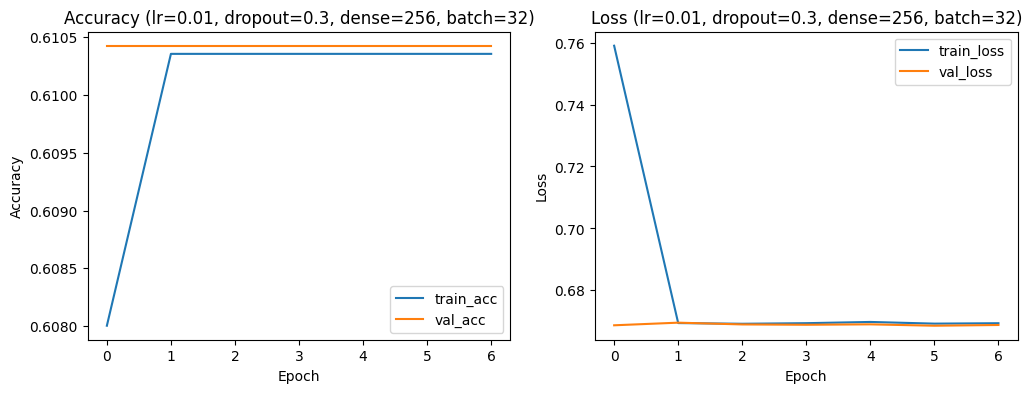


🔥 최종 최고 성능 모델 🔥
best_val_accuracy : 0.6104
best_params :
  learning_rate = 0.01
  dropout       = 0.3
  dense_units   = 256
  batch_size    = 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
예측: 뇌출혈 있음 (확률: 0.60)


In [ ]:
# 1️⃣ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import itertools
import matplotlib.pyplot as plt

# 3️⃣ 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 4️⃣ 이미지 데이터 전처리 및 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# 5️⃣ 커스텀 하이퍼파라미터 설정
param_grid = {
    "learning_rates": [1e-2],
    "dropouts": [0.3],
    "dense_units": [256],
    "batch_size": [32]
}

# 6️⃣ 모델 생성 함수
def create_model(learning_rate, dropout_rate, dense_units):
    model = Sequential([
        Input(shape=(128,128,3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7️⃣ 커스텀 튜닝 루프
best_acc = 0
best_params = None
best_model = None

combinations = list(itertools.product(
    param_grid["learning_rates"],
    param_grid["dropouts"],
    param_grid["dense_units"],
    param_grid["batch_size"]
))

print(f"총 실험 조합: {len(combinations)}")

for lr, dr, du, bs in combinations:
    print(f"\n===== 실험 조합 =====")
    print(f"learning_rate: {lr}, dropout: {dr}, dense_units: {du}, batch_size: {bs}")

    model = create_model(lr, dr, du)

    history = model.fit(
        train_generator,
        epochs=7,  # 빠른 튜닝용, 필요하면 늘리세요
        batch_size=bs,
        validation_data=test_generator,
        verbose=1
    )

    val_acc = max(history.history['val_accuracy'])
    print(f">>> 실험 성능 (최고 val_accuracy): {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, dr, du, bs)
        best_model = model
        model.save("/content/drive/MyDrive/brain_ct/best_custom_cnn_model_02.h5")
        print(">>> 새로운 베스트 모델 저장됨")



# 7️⃣-1. 학습 시각화 (Accuracy / Loss)
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'Accuracy (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Loss (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# 8️⃣ 최종 결과 출력
print("\n========================")
print("🔥 최종 최고 성능 모델 🔥")
print("========================")
print(f"best_val_accuracy : {best_acc:.4f}")
print(f"best_params :")
print(f"  learning_rate = {best_params[0]}")
print(f"  dropout       = {best_params[1]}")
print(f"  dense_units   = {best_params[2]}")
print(f"  batch_size    = {best_params[3]}")

# 9️⃣ 단일 이미지 예측 함수
def predict_image(image_path):
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = best_model.predict(img_array)[0][0]
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 10️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


===== 실험 조합 =====
learning_rate: 0.01, dropout: 0.3, dense_units: 256, batch_size: 32
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.5978 - loss: 1.0589 - val_accuracy: 0.6104 - val_loss: 0.6687
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6094 - loss: 0.6698 - val_accuracy: 0.6104 - val_loss: 0.6696
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5990 - loss: 0.6740 - val_accuracy: 0.6104 - val_loss: 0.6690
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6118 - loss: 0.6686 - val_accuracy: 0.6104 - val_loss: 0.6689
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6116 - loss: 0.6695 - val_accuracy: 0.6104 - val_loss: 0.6690
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6079 - loss: 0.6700 - val_accuracy: 0.6104 - val_loss: 0.6686
Epoch 7/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6085 - loss: 0.6699 - val_accuracy: 0.6104 - val_loss: 0.6688
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
>>> 실험 성능 (최고 val_accuracy): 0.6104

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
총 실험 조합: 1

===== 실험 조합 =====
learning_rate: 0.01, dropout: 0.3, dense_units: 256, batch_size: 64
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.5904 - loss: 1.6620 - val_accuracy: 0.6104 - val_loss: 0.6730
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6178 - loss: 0.6662 - val_accuracy: 0.6104 - val_loss: 0.6732
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6158 - loss: 0.6693 - val_accuracy: 0.6104 - val_loss: 0.6686
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6119 - loss: 0.6686 - val_accuracy: 0.6104 - val_loss: 0.6686
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6069 - loss: 0.6706 - val_accuracy: 0.6104 - val_loss: 0.6686
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/st

>>> 실험 성능 (최고 val_accuracy): 0.6104
>>> 새로운 베스트 모델 저장됨


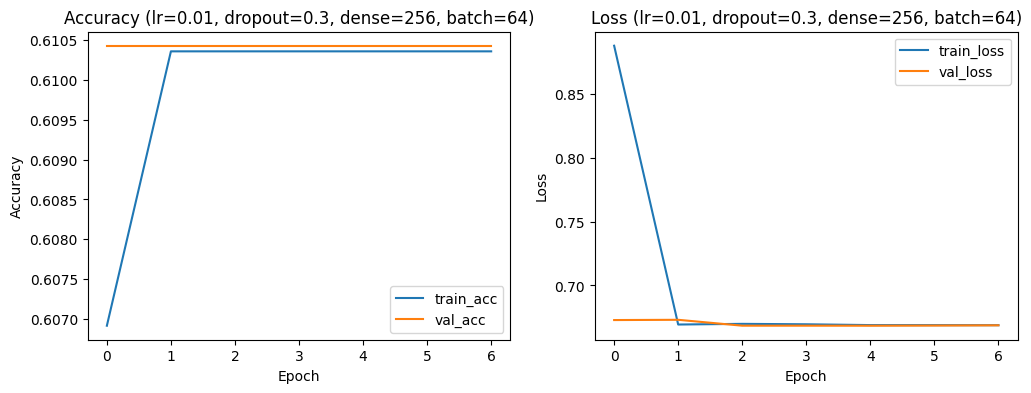


🔥 최종 최고 성능 모델 🔥
best_val_accuracy : 0.6104
best_params :
  learning_rate = 0.01
  dropout       = 0.3
  dense_units   = 256
  batch_size    = 64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
예측: 뇌출혈 있음 (확률: 0.60)


In [ ]:
# 1️⃣ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import itertools
import matplotlib.pyplot as plt

# 3️⃣ 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 4️⃣ 이미지 데이터 전처리 및 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# 5️⃣ 커스텀 하이퍼파라미터 설정
param_grid = {
    "learning_rates": [1e-2],
    "dropouts": [0.3],
    "dense_units": [256],
    "batch_size": [64]
}

# 6️⃣ 모델 생성 함수
def create_model(learning_rate, dropout_rate, dense_units):
    model = Sequential([
        Input(shape=(128,128,3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7️⃣ 커스텀 튜닝 루프
best_acc = 0
best_params = None
best_model = None

combinations = list(itertools.product(
    param_grid["learning_rates"],
    param_grid["dropouts"],
    param_grid["dense_units"],
    param_grid["batch_size"]
))

print(f"총 실험 조합: {len(combinations)}")

for lr, dr, du, bs in combinations:
    print(f"\n===== 실험 조합 =====")
    print(f"learning_rate: {lr}, dropout: {dr}, dense_units: {du}, batch_size: {bs}")

    model = create_model(lr, dr, du)

    history = model.fit(
        train_generator,
        epochs=7,  # 빠른 튜닝용, 필요하면 늘리세요
        batch_size=bs,
        validation_data=test_generator,
        verbose=1
    )

    val_acc = max(history.history['val_accuracy'])
    print(f">>> 실험 성능 (최고 val_accuracy): {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, dr, du, bs)
        best_model = model
        model.save("/content/drive/MyDrive/brain_ct/best_custom_cnn_model_03.h5")
        print(">>> 새로운 베스트 모델 저장됨")



# 7️⃣-1. 학습 시각화 (Accuracy / Loss)
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'Accuracy (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Loss (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# 8️⃣ 최종 결과 출력
print("\n========================")
print("🔥 최종 최고 성능 모델 🔥")
print("========================")
print(f"best_val_accuracy : {best_acc:.4f}")
print(f"best_params :")
print(f"  learning_rate = {best_params[0]}")
print(f"  dropout       = {best_params[1]}")
print(f"  dense_units   = {best_params[2]}")
print(f"  batch_size    = {best_params[3]}")

# 9️⃣ 단일 이미지 예측 함수
def predict_image(image_path):
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = best_model.predict(img_array)[0][0]
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 10️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


===== 실험 조합 =====
learning_rate: 0.01, dropout: 0.3, dense_units: 256, batch_size: 64
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.5904 - loss: 1.6620 - val_accuracy: 0.6104 - val_loss: 0.6730
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6178 - loss: 0.6662 - val_accuracy: 0.6104 - val_loss: 0.6732
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6158 - loss: 0.6693 - val_accuracy: 0.6104 - val_loss: 0.6686
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6119 - loss: 0.6686 - val_accuracy: 0.6104 - val_loss: 0.6686
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6069 - loss: 0.6706 - val_accuracy: 0.6104 - val_loss: 0.6686
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6217 - loss: 0.6640 - val_accuracy: 0.6104 - val_loss: 0.6687
Epoch 7/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6178 - loss: 0.6658 - val_accuracy: 0.6104 - val_loss: 0.6689
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
>>> 실험 성능 (최고 val_accuracy): 0.6104

# 전체 코드: CNN + 커스텀 튜닝 2  - 학습률 5e-4(0.0005), dropout 0.3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
총 실험 조합: 1

===== 실험 조합 =====
learning_rate: 0.0005, dropout: 0.3, dense_units: 128, batch_size: 16
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.6128 - loss: 0.6514 - val_accuracy: 0.7545 - val_loss: 0.4728
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.7321 - loss: 0.5266 - val_accuracy: 0.8342 - val_loss: 0.3530
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7885 - loss: 0.4496 - val_accuracy: 0.9044 - val_loss: 0.2474
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8618 - loss: 0.3292 - val_accuracy: 0.9117 - val_loss: 0.2099
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9015 - loss: 0.2483 - val_accuracy: 0.9232 - val_loss: 0.1904
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/

>>> 실험 성능 (최고 val_accuracy): 0.9544
>>> 새로운 베스트 모델 저장됨


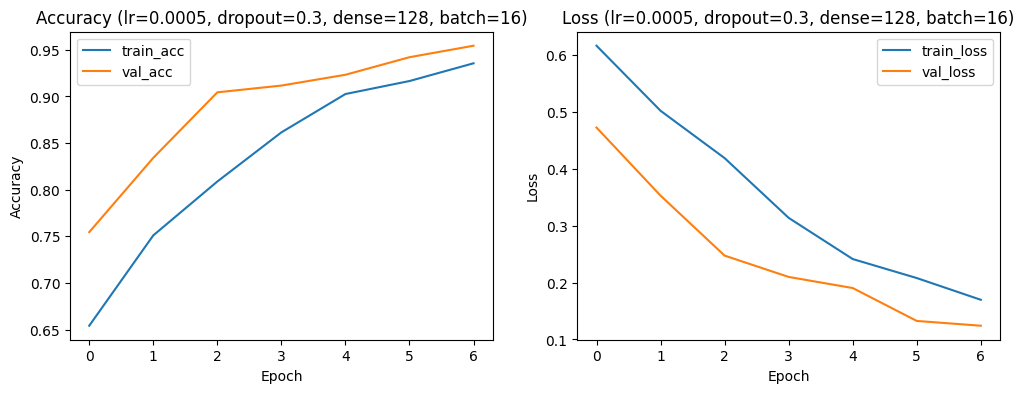


🔥 최종 최고 성능 모델 🔥
best_val_accuracy : 0.9544
best_params :
  learning_rate = 0.0005
  dropout       = 0.3
  dense_units   = 128
  batch_size    = 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
예측: 정상 (확률: 1.00)


In [ ]:
# 1️⃣ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import itertools
import matplotlib.pyplot as plt

# 3️⃣ 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 4️⃣ 이미지 데이터 전처리 및 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# 5️⃣ 커스텀 하이퍼파라미터 설정
param_grid = {
    "learning_rates": [5e-4],
    "dropouts": [0.3],
    "dense_units": [128],
    "batch_size": [16]
}

# 6️⃣ 모델 생성 함수
def create_model(learning_rate, dropout_rate, dense_units):
    model = Sequential([
        Input(shape=(128,128,3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7️⃣ 커스텀 튜닝 루프
best_acc = 0
best_params = None
best_model = None

combinations = list(itertools.product(
    param_grid["learning_rates"],
    param_grid["dropouts"],
    param_grid["dense_units"],
    param_grid["batch_size"]
))

print(f"총 실험 조합: {len(combinations)}")

for lr, dr, du, bs in combinations:
    print(f"\n===== 실험 조합 =====")
    print(f"learning_rate: {lr}, dropout: {dr}, dense_units: {du}, batch_size: {bs}")

    model = create_model(lr, dr, du)

    history = model.fit(
        train_generator,
        epochs=7,  # 빠른 튜닝용, 필요하면 늘리세요
        batch_size=bs,
        validation_data=test_generator,
        verbose=1
    )

    val_acc = max(history.history['val_accuracy'])
    print(f">>> 실험 성능 (최고 val_accuracy): {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, dr, du, bs)
        best_model = model
        model.save("/content/drive/MyDrive/brain_ct/best_custom_cnn_model4.h5")
        print(">>> 새로운 베스트 모델 저장됨")



# 7️⃣-1. 학습 시각화 (Accuracy / Loss)
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'Accuracy (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Loss (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# 8️⃣ 최종 결과 출력
print("\n========================")
print("🔥 최종 최고 성능 모델 🔥")
print("========================")
print(f"best_val_accuracy : {best_acc:.4f}")
print(f"best_params :")
print(f"  learning_rate = {best_params[0]}")
print(f"  dropout       = {best_params[1]}")
print(f"  dense_units   = {best_params[2]}")
print(f"  batch_size    = {best_params[3]}")

# 9️⃣ 단일 이미지 예측 함수
def predict_image(image_path):
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = best_model.predict(img_array)[0][0]
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 10️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


===== 실험 조합 =====
learning_rate: 0.0005, dropout: 0.3, dense_units: 128, batch_size: 16
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.6128 - loss: 0.6514 - val_accuracy: 0.7545 - val_loss: 0.4728
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.7321 - loss: 0.5266 - val_accuracy: 0.8342 - val_loss: 0.3530
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7885 - loss: 0.4496 - val_accuracy: 0.9044 - val_loss: 0.2474
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8618 - loss: 0.3292 - val_accuracy: 0.9117 - val_loss: 0.2099
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9015 - loss: 0.2483 - val_accuracy: 0.9232 - val_loss: 0.1904
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.9179 - loss: 0.2066 - val_accuracy: 0.9421 - val_loss: 0.1325
Epoch 7/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9306 - loss: 0.1746 - val_accuracy: 0.9544 - val_loss: 0.1241
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
>>> 실험 성능 (최고 val_accuracy): 0.9544

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
총 실험 조합: 1

===== 실험 조합 =====
learning_rate: 0.0005, dropout: 0.3, dense_units: 256, batch_size: 32
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.5931 - loss: 0.6815 - val_accuracy: 0.7393 - val_loss: 0.4839
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.7108 - loss: 0.5556 - val_accuracy: 0.8081 - val_loss: 0.3985
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7969 - loss: 0.4363 - val_accuracy: 0.8936 - val_loss: 0.2599
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8626 - loss: 0.3204 - val_accuracy: 0.8907 - val_loss: 0.2681
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.8789 - loss: 0.2843 - val_accuracy: 0.9276 - val_loss: 0.1602
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/

>>> 실험 성능 (최고 val_accuracy): 0.9602
>>> 새로운 베스트 모델 저장됨


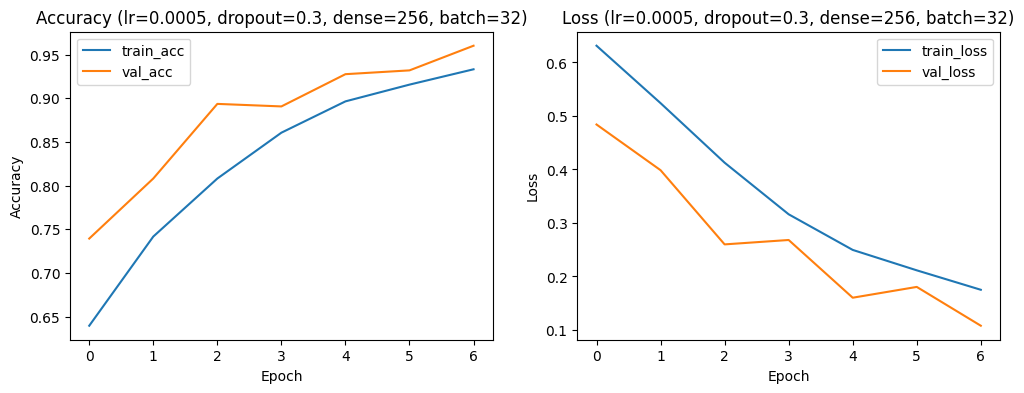


🔥 최종 최고 성능 모델 🔥
best_val_accuracy : 0.9602
best_params :
  learning_rate = 0.0005
  dropout       = 0.3
  dense_units   = 256
  batch_size    = 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
예측: 정상 (확률: 0.98)


In [ ]:
# 1️⃣ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import itertools
import matplotlib.pyplot as plt

# 3️⃣ 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 4️⃣ 이미지 데이터 전처리 및 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# 5️⃣ 커스텀 하이퍼파라미터 설정
param_grid = {
    "learning_rates": [5e-4],
    "dropouts": [0.3],
    "dense_units": [256],
    "batch_size": [32]
}

# 6️⃣ 모델 생성 함수
def create_model(learning_rate, dropout_rate, dense_units):
    model = Sequential([
        Input(shape=(128,128,3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7️⃣ 커스텀 튜닝 루프
best_acc = 0
best_params = None
best_model = None

combinations = list(itertools.product(
    param_grid["learning_rates"],
    param_grid["dropouts"],
    param_grid["dense_units"],
    param_grid["batch_size"]
))

print(f"총 실험 조합: {len(combinations)}")

for lr, dr, du, bs in combinations:
    print(f"\n===== 실험 조합 =====")
    print(f"learning_rate: {lr}, dropout: {dr}, dense_units: {du}, batch_size: {bs}")

    model = create_model(lr, dr, du)

    history = model.fit(
        train_generator,
        epochs=7,  # 빠른 튜닝용, 필요하면 늘리세요
        batch_size=bs,
        validation_data=test_generator,
        verbose=1
    )

    val_acc = max(history.history['val_accuracy'])
    print(f">>> 실험 성능 (최고 val_accuracy): {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, dr, du, bs)
        best_model = model
        model.save("/content/drive/MyDrive/brain_ct/best_custom_cnn_model5.h5")
        print(">>> 새로운 베스트 모델 저장됨")



# 7️⃣-1. 학습 시각화 (Accuracy / Loss)
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'Accuracy (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Loss (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# 8️⃣ 최종 결과 출력
print("\n========================")
print("🔥 최종 최고 성능 모델 🔥")
print("========================")
print(f"best_val_accuracy : {best_acc:.4f}")
print(f"best_params :")
print(f"  learning_rate = {best_params[0]}")
print(f"  dropout       = {best_params[1]}")
print(f"  dense_units   = {best_params[2]}")
print(f"  batch_size    = {best_params[3]}")

# 9️⃣ 단일 이미지 예측 함수
def predict_image(image_path):
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = best_model.predict(img_array)[0][0]
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 10️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


===== 실험 조합 =====
learning_rate: 0.0005, dropout: 0.3, dense_units: 256, batch_size: 32
Epoch 1/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.5931 - loss: 0.6815 - val_accuracy: 0.7393 - val_loss: 0.4839
Epoch 2/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.7108 - loss: 0.5556 - val_accuracy: 0.8081 - val_loss: 0.3985
Epoch 3/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7969 - loss: 0.4363 - val_accuracy: 0.8936 - val_loss: 0.2599
Epoch 4/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8626 - loss: 0.3204 - val_accuracy: 0.8907 - val_loss: 0.2681
Epoch 5/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.8789 - loss: 0.2843 - val_accuracy: 0.9276 - val_loss: 0.1602
Epoch 6/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9155 - loss: 0.2136 - val_accuracy: 0.9319 - val_loss: 0.1804
Epoch 7/7
173/173 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9286 - loss: 0.1879 - val_accuracy: 0.9602 - val_loss: 0.1079
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
>>> 실험 성능 (최고 val_accuracy): 0.9602

### 위 결과를 바탕으로 최적의 하이퍼파라미터 값 찾으면 됨

# 2. ResNet50 기반으로 신경망 변경하여 튜닝하기

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.5873 - loss: 0.6980 - val_accuracy: 0.6104 - val_loss: 0.6586
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.5828 - loss: 0.6843 - val_accuracy: 0.6104 - val_loss: 0.6510
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.6051 - loss: 0.6704 - val_accuracy: 0.6119 - val_loss: 0.6449
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.6037 - loss: 0.6648 - val_accuracy: 0.6104 - val_loss: 0.6438
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.6244 - loss: 0.6540 - val_accuracy: 0.6119 - val_loss: 0.6348
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.6176 - loss: 0.6544 - va

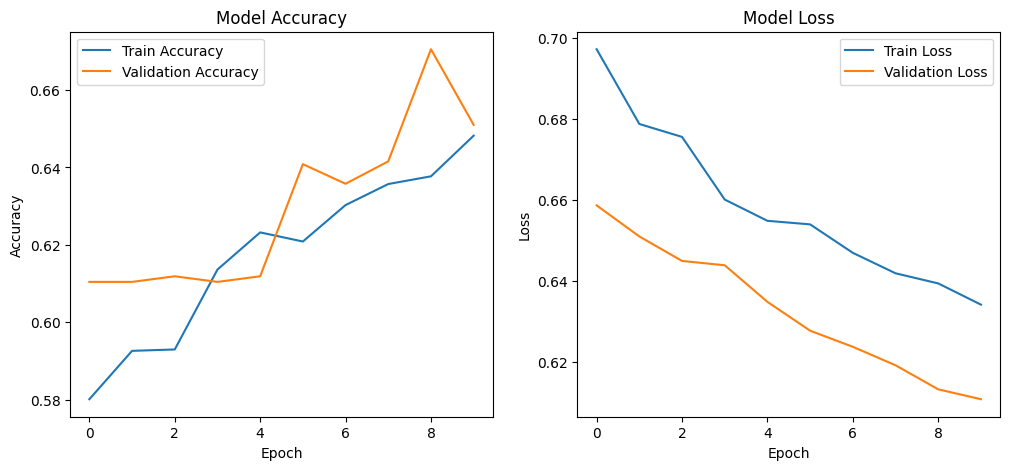

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
예측: 뇌출혈 있음 (확률: 0.66)


In [ ]:
# 1️⃣ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')
# Colab에서 구글 드라이브를 마운트합니다.
# 마운트 후 '/content/drive/MyDrive/...' 경로를 통해 파일 접근 가능

# 2️⃣ 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# 3️⃣ 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 4️⃣ 이미지 데이터 전처리 및 증강
# ImageDataGenerator를 활용하면 실시간 데이터 증강 및 정규화 가능
train_datagen = ImageDataGenerator(
    rescale=1./255,      # 픽셀 값 0~255 → 0~1 정규화
    shear_range=0.2,     # 이미지 기울기 변환
    zoom_range=0.2,      # 이미지 확대/축소
    horizontal_flip=True # 좌우 반전 (CT에서는 해석 주의)
)
test_datagen = ImageDataGenerator(
    rescale=1./255       # 검증 데이터는 증강 없이 정규화만 수행
)

# 학습/검증 데이터 제너레이터 생성
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),  # 모델 입력 크기로 통일
    batch_size=32,          # 한 번에 학습할 이미지 수
    class_mode='binary'     # 이진 분류 (0: 정상, 1: 뇌출혈)
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# 5️⃣ ResNet50 기반 Transfer Learning 모델 정의
# pretrained ResNet50 모델 불러오기, include_top=False → 최상위 분류층 제거
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

# ResNet50의 기존 layer는 학습하지 않도록 동결
# 이유: pretrained weights 활용, 초기 학습 안정성 확보
for layer in base_model.layers:
    layer.trainable = False

# ResNet50 출력에 GlobalAveragePooling을 적용 → 1D 벡터로 변환
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Dense 레이어 추가 → feature 조합 학습
x = Dense(256, activation='relu')(x)

# Dropout → 과적합 방지
x = Dropout(0.4)(x)

# 최종 출력층 → 이진 분류
predictions = Dense(1, activation='sigmoid')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 6️⃣ 모델 컴파일
# optimizer: Adam, learning_rate=1e-4
# loss: binary_crossentropy (이진 분류)
# metrics: accuracy (정확도)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 7️⃣ 모델 학습
# train_generator를 이용하여 epochs=10 동안 학습
# validation_data=test_generator로 검증 정확도 확인
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# 8️⃣ 학습 시각화 (Accuracy / Loss)
plt.figure(figsize=(12,5))

# 8-1. 정확도 그래프
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')         # 학습 정확도
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')# 검증 정확도
plt.title('Model Accuracy')       # 그래프 제목
plt.xlabel('Epoch')               # x축: 에포크
plt.ylabel('Accuracy')            # y축: 정확도
plt.legend()                      # 범례 표시

# 8-2. 손실(Loss) 그래프
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')                 # 학습 손실
plt.plot(history.history['val_loss'], label='Validation Loss')        # 검증 손실
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()  # 그래프 출력

# 9️⃣ 단일 이미지 예측 함수
def predict_image(image_path):
    """
    이미지 경로를 입력받아 뇌출혈 여부 예측
    출력: '뇌출혈 있음' / '정상'과 확률
    """
    # 이미지 불러오기 + 크기 변환
    img = load_img(image_path, target_size=(128,128))
    # 이미지 → 배열 변환 후 0~1 정규화
    img_array = img_to_array(img)/255.0
    # 배치 차원 추가 (모델 입력 형태: [1,128,128,3])
    img_array = np.expand_dims(img_array, axis=0)
    # 예측 수행
    pred = model.predict(img_array)[0][0]
    # 결과 출력
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 10️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.5873 - loss: 0.6980 - val_accuracy: 0.6104 - val_loss: 0.6586
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.5828 - loss: 0.6843 - val_accuracy: 0.6104 - val_loss: 0.6510
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.6051 - loss: 0.6704 - val_accuracy: 0.6119 - val_loss: 0.6449
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.6037 - loss: 0.6648 - val_accuracy: 0.6104 - val_loss: 0.6438
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.6244 - loss: 0.6540 - val_accuracy: 0.6119 - val_loss: 0.6348
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.6176 - loss: 0.6544 - val_accuracy: 0.6408 - val_loss: 0.6276
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.6286 - loss: 0.6516 - val_accuracy: 0.6358 - val_loss: 0.6237
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.6352 - loss: 0.6438 - val_accuracy: 0.6416 - val_loss: 0.6191
Epoch 9/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.6380 - loss: 0.6395 - val_accuracy: 0.6705 - val_loss: 0.6131
Epoch 10/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.6506 - loss: 0.6343 - val_accuracy: 0.6510 - val_loss: 0.6107


예측: 뇌출혈 있음 (확률: 0.66)

# ResNet50 커스텀 튜닝

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
총 실험 조합: 1

===== 실험 조합 =====
learning_rate=0.0001, dropout=0.3, dense_units=128, batch_size=16
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.5733 - loss: 0.6907 - val_accuracy: 0.6104 - val_loss: 0.6641
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.6044 - loss: 0.6714 - val_accuracy: 0.6104 - val_loss: 0.6531
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.5965 - loss: 0.6696 - val_accuracy: 0.6104 - val_loss: 0.6461
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.6129 - loss: 0.6613 - val_accuracy: 0.6104 - val_loss: 0.6402
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.6347 - loss: 0.6444 - val_accuracy: 0.6416 - val_loss: 0.6330
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 396s 1

>>> 실험 성능 (최고 val_accuracy): 0.6430
>>> 새로운 베스트 모델 저장됨: /content/drive/MyDrive/brain_ct/best_resnet_model.h5


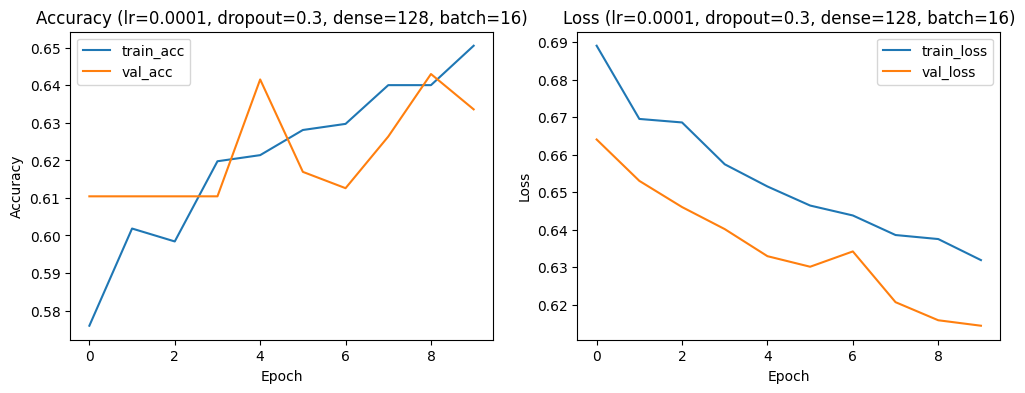


🔥 최종 최고 성능 모델 🔥
best_val_accuracy : 0.6430
best_params :
  learning_rate = 0.0001
  dropout       = 0.3
  dense_units   = 128
  batch_size    = 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
예측: 뇌출혈 있음 (확률: 0.67)


In [ ]:
# 1️⃣ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')
# Colab에서 Google Drive를 마운트합니다.
# 마운트 후 '/content/drive/MyDrive/...' 경로를 통해 데이터와 모델을 접근할 수 있습니다.

# 2️⃣ 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import itertools
import hashlib
import os

# 3️⃣ 데이터 경로 설정
train_dir = '/content/drive/MyDrive/brain_ct/train'  # 학습용 이미지 폴더
test_dir = '/content/drive/MyDrive/brain_ct/test'    # 검증용 이미지 폴더

# 4️⃣ 이미지 데이터 전처리 및 증강
# ImageDataGenerator를 사용하면 실시간으로 데이터 증강을 수행할 수 있음
train_datagen = ImageDataGenerator(
    rescale=1./255,      # 픽셀 값 0~255를 0~1 범위로 정규화
    shear_range=0.2,     # 이미지 기울기(shear) 변환
    zoom_range=0.2,      # 이미지 확대/축소
    horizontal_flip=True # 좌우 반전
)
test_datagen = ImageDataGenerator(
    rescale=1./255       # 검증 데이터는 증강 없이 정규화만 수행
)

# 5️⃣ 커스텀 하이퍼파라미터 설정
# 실험할 learning rate, dropout 비율, dense 유닛, batch_size 조합 정의
param_grid = {
    "learning_rates": [1e-4],   # 학습률 후보
    "dropouts": [0.3],           # Dropout 후보
    "dense_units": [128],        # Fully connected layer 유닛 후보
    "batch_size": [16]            # 배치 크기 후보
}

# 6️⃣ ResNet50 기반 모델 생성 함수
def create_model(learning_rate, dropout_rate, dense_units):
    """
    ResNet50 기반 이진 분류 모델 생성
    입력:
        learning_rate: 학습률
        dropout_rate: Dropout 비율
        dense_units: FC layer 유닛 수
    출력:
        컴파일된 Keras 모델
    """
    # 사전 학습된 ResNet50 불러오기 (imagenet 가중치 사용)
    # include_top=False로 출력층 제거, 입력 크기는 (128,128,3)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

    # Feature extractor로 사용하기 위해 모든 레이어 동결
    for layer in base_model.layers:
        layer.trainable = False

    # GlobalAveragePooling2D를 통해 feature map을 1차원 벡터로 변환
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer + Dropout
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # 출력층: sigmoid activation으로 이진 분류
    predictions = Dense(1, activation='sigmoid')(x)

    # 모델 정의 및 컴파일
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7️⃣ 커스텀 튜닝 루프
# 모든 하이퍼파라미터 조합에 대해 모델 학습 및 검증
best_acc = 0          # 최고 검증 정확도 초기화
best_params = None    # 최고 성능 조합 초기화
best_model = None     # 최고 성능 모델 초기화

# 모든 조합 생성 (learning_rate, dropout, dense_units, batch_size)
combinations = list(itertools.product(
    param_grid["learning_rates"],
    param_grid["dropouts"],
    param_grid["dense_units"],
    param_grid["batch_size"]
))

print(f"총 실험 조합: {len(combinations)}")

for lr, dr, du, bs in combinations:
    print(f"\n===== 실험 조합 =====")
    print(f"learning_rate={lr}, dropout={dr}, dense_units={du}, batch_size={bs}")

    # 배치 크기에 따라 generator 재생성
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128,128),
        batch_size=bs,
        class_mode='binary'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128,128),
        batch_size=bs,
        class_mode='binary'
    )

    # 모델 생성
    model = create_model(lr, dr, du)

    # 모델 학습
    # generator를 사용하면 batch_size를 fit에서 지정할 필요 없음
    history = model.fit(
        train_generator,
        epochs=10,  # 빠른 튜닝용, 실제 학습 시 늘릴 수 있음
        validation_data=test_generator,
        verbose=1
    )

    # 검증 정확도 최고값
    val_acc = max(history.history['val_accuracy'])
    print(f">>> 실험 성능 (최고 val_accuracy): {val_acc:.4f}")

    # 최고 성능 모델 저장
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, dr, du, bs)
        best_model = model

        # MD5 해시 생성 (하이퍼파라미터 기반)
        save_path = f"/content/drive/MyDrive/brain_ct/best_resnet_model.h5"

        model.save(save_path)  # 모델 저장
        print(f">>> 새로운 베스트 모델 저장됨: {save_path}")

        # 학습 시각화 (Accuracy / Loss)
        plt.figure(figsize=(12,4))

        # 7️⃣-1. Accuracy 시각화
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='train_acc')
        plt.plot(history.history['val_accuracy'], label='val_acc')
        plt.title(f'Accuracy (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # 7️⃣-2. Loss 시각화
        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title(f'Loss (lr={lr}, dropout={dr}, dense={du}, batch={bs})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# 8️⃣ 최종 최고 성능 모델 정보 출력
print("\n========================")
print("🔥 최종 최고 성능 모델 🔥")
print("========================")
print(f"best_val_accuracy : {best_acc:.4f}")
print(f"best_params :")
print(f"  learning_rate = {best_params[0]}")
print(f"  dropout       = {best_params[1]}")
print(f"  dense_units   = {best_params[2]}")
print(f"  batch_size    = {best_params[3]}")

# 9️⃣ 단일 이미지 예측 함수
def predict_image(image_path):
    """
    단일 이미지 예측
    입력: image_path (str) - 이미지 파일 경로
    출력: 예측 결과 출력
    """
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0  # 정규화
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    pred = best_model.predict(img_array)[0][0]
    if pred > 0.5:
        print(f"예측: 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: 정상 (확률: {1-pred:.2f})")

# 10️⃣ 예시 사용
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


총 실험 조합: 2

===== 실험 조합 =====
learning_rate=0.001, dropout=0.3, dense_units=128, batch_size=16
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.5707 - loss: 0.6981 - val_accuracy: 0.6104 - val_loss: 0.6480
Epoch 2/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.6220 - loss: 0.6504 - val_accuracy: 0.6104 - val_loss: 0.6768
Epoch 3/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.6198 - loss: 0.6565 - val_accuracy: 0.6155 - val_loss: 0.6323
Epoch 4/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.6475 - loss: 0.6322 - val_accuracy: 0.6843 - val_loss: 0.5848
Epoch 5/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.6575 - loss: 0.6262 - val_accuracy: 0.6879 - val_loss: 0.5820
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
>>> 실험 성능 (최고 val_accuracy): 0.6879

# Transfer Learning + Freeze

사전 학습된 ResNet50 등 모델 활용

대부분의 레이어 Freeze → 업데이트되는 파라미터가 마지막 Dense 레이어 정도로 줄어듦

효과: 에포크당 학습 시간 수분 내로 단축 가능, 데이터가 적어도 정확도 확보 가능

In [3]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# ===============================
# 데이터 경로
# ===============================
train_dir = '/content/drive/MyDrive/brain_ct/train'
test_dir = '/content/drive/MyDrive/brain_ct/test'

# ===============================
# 이미지 데이터 전처리
# ===============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

# ===============================
# ResNet50 전이학습 모델 정의
# ===============================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

# 기존 레이어 Freeze
for layer in base_model.layers:
    layer.trainable = False

# 새로운 출력층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# ===============================
# 모델 컴파일
# ===============================
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ===============================
# 모델 학습
# ===============================
# 에포크 3~5 정도면 충분히 빠름
history = model.fit(train_generator, epochs=3, validation_data=test_generator)

# ===============================
# 모델 저장
# ===============================
model_save_path = '/content/drive/MyDrive/brain_ct/best_resnet_transfer.h5'
model.save(model_save_path)
print(f"모델이 저장되었습니다: {model_save_path}")

# ===============================
# 단일 이미지 예측 함수
# ===============================
def predict_image(image_path):
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    if pred > 0.5:
        print(f"예측: 🟥 뇌출혈 있음 (확률: {pred:.2f})")
    else:
        print(f"예측: ✅ 정상 (확률: {1-pred:.2f})")

# ===============================
# 예시 이미지 예측
# ===============================
predict_image('/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/3
173/173 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.5843 - loss: 0.6895 - val_accuracy: 0.6104 - val_loss: 0.6631
Epoch 2/3
173/173 ━━━━━━━━━━━━━━━━━━━━ 54s 313ms/step - accuracy: 0.5994 - loss: 0.6758 - val_accuracy: 0.6104 - val_loss: 0.6564
Epoch 3/3
173/173 ━━━━━━━━━━━━━━━━━━━━ 54s 311ms/step - accuracy: 0.6011 - loss: 0.6675 - val_accuracy: 0.6104 - val_loss: 0.6530


모델이 저장되었습니다: /content/drive/MyDrive/brain_ct/best_resnet_transfer.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
예측: 🟥 뇌출혈 있음 (확률: 0.62)


# Streamlit 실행 파일 - 로컬용

In [ ]:
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# 화면 와이드 모드
st.set_page_config(layout="wide", page_title="뇌출혈 예측 비교")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

st.markdown("## 🧠 뇌출혈 예측 비교 (CNN vs ResNet)")
st.write("왼쪽 사이드바에서 이미지를 업로드하고 모델을 선택하면 예측 결과가 표시됩니다.")

CNN_MODEL_PATH = "model/best_custom_cnn_model_03.h5"
RESNET_MODEL_PATH = "model/best_resnet_model.h5"

@st.cache_resource
def load_models():
    return load_model(CNN_MODEL_PATH), load_model(RESNET_MODEL_PATH)

cnn_model, resnet_model = load_models()

def preprocess_image(img_file, target_size=(128,128)):
    img = load_img(img_file, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# ===============================
# 사이드바
# ===============================
st.sidebar.header("🔧 설정")
uploaded_file = st.sidebar.file_uploader("이미지를 업로드하세요 (jpg/png)", type=["jpg","jpeg","png"])
selected_model = st.sidebar.radio("모델 선택", ("CNN", "ResNet", "둘 다"))

if uploaded_file is not None:
    img_array = preprocess_image(uploaded_file)
    left_col, right_col = st.columns([3, 7])

    # -------------------------------
    # 왼쪽: 이미지
    # -------------------------------
    with left_col:
        st.image(uploaded_file, caption="업로드된 이미지", use_container_width=True)

    # -------------------------------
    # 오른쪽: 결과 카드 + 막대그래프(둘 다 선택 시)
    # -------------------------------
    with right_col:
        st.markdown("### 📊 예측 결과")

        results = {}
        if selected_model in ("CNN", "둘 다"):
            pred = cnn_model.predict(img_array)[0][0]
            result_text = "🟥 뇌출혈 있음" if pred > 0.5 else "✅ 정상"
            prob = pred if pred > 0.5 else 1 - pred
            results['CNN'] = (result_text, prob)

        if selected_model in ("ResNet", "둘 다"):
            pred = resnet_model.predict(img_array)[0][0]
            result_text = "🟥 뇌출혈 있음" if pred > 0.5 else "✅ 정상"
            prob = pred if pred > 0.5 else 1 - pred
            results['ResNet'] = (result_text, prob)

        # 카드형 결과 표시
        for model_name, (res, prob) in results.items():
            color = "#ff4b4b" if res.startswith("🟥") else "#4CAF50"
            st.markdown(f"""
                <div style="padding:15px; border-radius:10px; background-color:{color}; color:white; margin-bottom:10px;">
                    <h4>{model_name} 모델</h4>
                    <p style="font-size:20px; margin:0;">{res}</p>
                </div>
                """, unsafe_allow_html=True)

        # -------------------------------
        # 막대그래프 (둘 다 선택 시만)
        # -------------------------------
        if selected_model == "둘 다":
            fig, ax = plt.subplots(figsize=(6,4))
            labels = list(results.keys())
            probs = [results[m][1] for m in labels]
            colors = ['#ff4b4b' if results[m][0].startswith("🟥") else '#4CAF50' for m in labels]

            bars = ax.bar(labels, probs, color=colors, alpha=0.8)
            ax.set_ylim(0,1)
            ax.set_ylabel("확률")
            ax.set_title("모델별 뇌출혈 예측 확률")

            # 막대 위에 확률 표시
            for bar, prob in zip(bars, probs):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{prob*100:.1f}%", ha='center', fontweight='bold')

            st.pyplot(fig)


# Ver2.0

## 01. cnn

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import numpy as np

# -----------------------------
# 1. 데이터 준비
# -----------------------------
train_dir = "/content/drive/MyDrive/brain_ct/train"
test_dir = "/content/drive/MyDrive/brain_ct/test"

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# -----------------------------
# 2. CNN 모델 정의
# -----------------------------
def create_simple_cnn(input_shape=(224,224,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = create_simple_cnn()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# -----------------------------
# 3. 학습
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop]
)

# -----------------------------
# 4. 모델 저장
# -----------------------------
cnn_model.save("/content/drive/MyDrive/cnn_brain_ct.h5")

# -----------------------------
# 5. 테스트 데이터 정확도
# -----------------------------
loss, acc = cnn_model.evaluate(test_generator)
print(f"CNN 모델 테스트 정확도: {acc*100:.2f}%")

# -----------------------------
# 6. 임의 이미지 예측
# -----------------------------
img_path = "/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg"
img = image.load_img(img_path, target_size=img_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

pred = cnn_model.predict(x)[0][0]
label = "hemorrhage" if pred >= 0.5 else "normal"
print(f"CNN 모델 예측: {label} ({pred:.4f})")


Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 95s 529ms/step - accuracy: 0.6538 - loss: 0.7213 - val_accuracy: 0.7741 - val_loss: 0.5768
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 88s 505ms/step - accuracy: 0.7523 - loss: 0.4961 - val_accuracy: 0.8516 - val_loss: 0.3502
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 87s 505ms/step - accuracy: 0.8408 - loss: 0.3733 - val_accuracy: 0.9095 - val_loss: 0.2040
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 87s 504ms/step - accuracy: 0.9016 - loss: 0.2401 - val_accuracy: 0.9290 - val_loss: 0.1553
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 86s 499ms/step - accuracy: 0.9333 - loss: 0.1659 - val_accuracy: 0.9529 - val_loss: 0.1233
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 88s 508ms/step - accuracy: 0.9472 - loss: 0.1300 - val_accuracy: 0.9776 - val_loss: 0.0673
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 88s 509ms/step - accuracy: 0.9600 - loss: 0.1059 - val_accuracy: 0.9884 - val_loss: 0.0470
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 87s 504ms/step - accuracy: 0.9685 - loss: 0

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9868 - loss: 0.0565
CNN 모델 테스트 정확도: 99.13%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
CNN 모델 예측: normal (0.0001)


## 2. ResNet from scratch

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np

# -----------------------------
# 1. 데이터 준비
# -----------------------------
train_dir = "/content/drive/MyDrive/brain_ct/train"
test_dir = "/content/drive/MyDrive/brain_ct/test"

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# -----------------------------
# 2. ResNet from scratch 정의
# -----------------------------
def create_resnet_from_scratch(input_shape=(224,224,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    for filters in [64,128,256]:
        x = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2,2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

resnet_scratch = create_resnet_from_scratch()
resnet_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_scratch.summary()

# -----------------------------
# 3. 학습
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

resnet_scratch.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop]
)

# -----------------------------
# 4. 모델 저장
# -----------------------------
resnet_scratch.save("/content/drive/MyDrive/resnet_scratch_brain_ct.h5")

# -----------------------------
# 5. 테스트 데이터 정확도
# -----------------------------
loss, acc = resnet_scratch.evaluate(test_generator)
print(f"ResNet scratch 테스트 정확도: {acc*100:.2f}%")

# -----------------------------
# 6. 임의 이미지 예측
# -----------------------------
img_path = "/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg"
img = image.load_img(img_path, target_size=img_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

pred = resnet_scratch.predict(x)[0][0]
label = "hemorrhage" if pred >= 0.5 else "normal"
print(f"ResNet scratch 예측: {label} ({pred:.4f})")


Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,223,041 (4.67 MB)

 Trainable params: 1,223,041 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 103s 548ms/step - accuracy: 0.6178 - loss: 0.6839 - val_accuracy: 0.6104 - val_loss: 0.6683
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 86s 499ms/step - accuracy: 0.6019 - loss: 0.6719 - val_accuracy: 0.6104 - val_loss: 0.6773
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 88s 506ms/step - accuracy: 0.6264 - loss: 0.6583 - val_accuracy: 0.6524 - val_loss: 0.6379
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 87s 504ms/step - accuracy: 0.6464 - loss: 0.6396 - val_accuracy: 0.6524 - val_loss: 0.6805
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 87s 505ms/step - accuracy: 0.6655 - loss: 0.6212 - val_accuracy: 0.6988 - val_loss: 0.5636
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 86s 499ms/step - accuracy: 0.6997 - loss: 0.5659 - val_accuracy: 0.7038 - val_loss: 0.5433
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 89s 514ms/step - accuracy: 0.7221 - loss: 0.5293 - val_accuracy: 0.8045 - val_loss: 0.4445
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 88s 507ms/step - accuracy: 0.7795 - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7090 - loss: 0.5729
ResNet scratch 테스트 정확도: 84.50%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
ResNet scratch 예측: normal (0.0000)


# ResNet50 전이학습

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import numpy as np

# -----------------------------
# 1. 데이터 준비
# -----------------------------
train_dir = "/content/drive/MyDrive/brain_ct/train"
test_dir = "/content/drive/MyDrive/brain_ct/test"

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# -----------------------------
# 2. ResNet50 전이학습 정의 (freeze)
# -----------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

resnet_transfer = Model(inputs=base_model.input, outputs=outputs)
resnet_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_transfer.summary()

# -----------------------------
# 3. 학습
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

resnet_transfer.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop]
)

# -----------------------------
# 4. 모델 저장
# -----------------------------
resnet_transfer.save("/content/drive/MyDrive/resnet_transfer_brain_ct.h5")

# -----------------------------
# 5. 테스트 데이터 정확도
# -----------------------------
loss, acc = resnet_transfer.evaluate(test_generator)
print(f"ResNet50 transfer 테스트 정확도: {acc*100:.2f}%")

# -----------------------------
# 6. 임의 이미지 예측
# -----------------------------
img_path = "/content/drive/MyDrive/brain_ct/test/hemorrhage/ds1_0_hemorrhage_1026_IMG-0001-00073.jpg"
img = image.load_img(img_path, target_size=img_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

pred = resnet_transfer.predict(x)[0][0]
label = "hemorrhage" if pred >= 0.5 else "normal"
print(f"ResNet50 transfer 예측: {label} ({pred:.4f})")


Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 112s 585ms/step - accuracy: 0.5836 - loss: 0.6764 - val_accuracy: 0.6379 - val_loss: 0.6057
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 126s 524ms/step - accuracy: 0.6463 - loss: 0.6248 - val_accuracy: 0.7299 - val_loss: 0.5491
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 520ms/step - accuracy: 0.6953 - loss: 0.5849 - val_accuracy: 0.7393 - val_loss: 0.5150
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 524ms/step - accuracy: 0.7087 - loss: 0.5575 - val_accuracy: 0.7603 - val_loss: 0.4893
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 525ms/step - accuracy: 0.7209 - loss: 0.5469 - val_accuracy: 0.7668 - val_loss: 0.4729
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 522ms/step - accuracy: 0.7406 - loss: 0.5157 - val_accuracy: 0.7495 - val_loss: 0.4751
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 520ms/step - accuracy: 0.7555 - loss: 0.4883 - val_accuracy: 0.7610 - val_loss: 0.4766
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 517ms/step - accuracy: 0.7533 - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.7336 - loss: 0.4692
ResNet50 transfer 테스트 정확도: 80.45%
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
ResNet50 transfer 예측: hemorrhage (0.5980)


1. 데이터셋 규모와 모델 복잡도

CNN 모델: 비교적 간단한 구조, 파라미터 수 적음 → 5000장 정도의 데이터셋에서 충분히 학습 가능

ResNet from scratch: 깊은 모델, 파라미터 많음 → 데이터가 적으면 오히려 과적합(overfitting)되거나 제대로 학습되지 않을 수 있음

ResNet50 transfer: 사전 학습된 가중치를 freeze → Dense만 학습

만약 데이터가 ResNet50이 ImageNet으로 학습된 특성과 많이 다르면, Dense만 학습하는 것이 최적화가 충분하지 않을 수 있음

2. 학습 조건

에포크 수가 적으면 간단한 CNN은 빨리 수렴

ResNet scratch는 깊어서 충분히 학습되지 않았을 가능성

ResNet50 transfer는 Dense만 학습 → 일부 데이터에서는 CNN보다 예측력이 낮을 수 있음

3. 결론

작은/중간 규모 데이터셋에서는 단순 CNN이 더 잘 맞는 경우가 많습니다

ResNet 계열은 데이터가 많거나 사전학습 가중치 fine-tuning을 할 때 더 강력해집니다

# ResNet50 transfer 모델을 fine-tuning

1. 클래스 균형 맞추기
ImageDataGenerator에서 class_weight를 설정하여 hemorrhage/normal 샘플 비율을 맞춤

2. 현재 Dense만 학습했기 때문에 hemorrhage 특징은 잘 잡지만 normal 특징은 부족하기에 해결하려면 부분 unfreeze + fine-tuning + 클래스 균형 + augmentation 조합

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# -----------------------------
# 1. 데이터 준비
# -----------------------------
train_dir = "/content/drive/MyDrive/brain_ct/train"
test_dir = "/content/drive/MyDrive/brain_ct/test"

# 데이터 증강 (preprocess_input 포함)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),  # 이미지 크기 축소
    batch_size=32,           # 배치 사이즈 증가
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# -----------------------------
# 2. ResNet50 base model 불러오기 (pretrained)
# -----------------------------
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)

# -----------------------------
# 3. Top layers 구성
# -----------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# -----------------------------
# 4. 학습: base model freeze (Dense만 학습)
# -----------------------------
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=5,                 # epoch 최소화
    validation_data=test_generator
)

# -----------------------------
# 5. 모델 저장
# -----------------------------
model.save("/content/drive/MyDrive/resnet_transfer_fast_brain_ct.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5523 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 820s 5s/step - accuracy: 0.6845 - loss: 0.7128 - val_accuracy: 0.8074 - val_loss: 0.4306
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.8027 - loss: 0.4268 - val_accuracy: 0.8472 - val_loss: 0.3804
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - accuracy: 0.8377 - loss: 0.3517 - val_accuracy: 0.8617 - val_loss: 0.3449
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.8532 - loss: 0.3329 - val_accuracy: 0.8573 - val_loss: 0.3313
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step - accuracy: 0.8662 - loss: 0.3132 - val_accuracy: 0.8783 - val_loss: 0.2963


# streamlit

In [ ]:
# streamlit_brain_ct_app_sidebar_single_model.py
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

st.title("뇌출혈 예측 웹앱")
st.write("사이드바에서 이미지를 업로드하고 모델을 선택하세요.")

# -----------------------------
# 1. 사이드바: 이미지 업로드
# -----------------------------
uploaded_file = st.sidebar.file_uploader("이미지 업로드", type=["jpg","png","jpeg"])

# -----------------------------
# 2. 사이드바: 모델 선택
# -----------------------------
model_option = st.sidebar.radio(
    "모델 선택",
    ("CNN", "ResNet from scratch", "ResNet50 transfer", "ResNet50 fine-tuned")
)

# -----------------------------
# 3. 모델 로드 (캐시)
# -----------------------------
@st.cache_resource
def load_models():
    cnn_model = load_model("model/cnn_brain_ct.h5")
    resnet_scratch = load_model("model/resnet_scratch_brain_ct.h5")
    resnet_transfer = load_model("model/resnet_transfer_brain_ct.h5")
    resnet_finetuned = load_model("model/resnet_transfer_fast_brain_ct.h5")  # Dense-only 빠른 학습
    return cnn_model, resnet_scratch, resnet_transfer, resnet_finetuned

cnn_model, resnet_scratch, resnet_transfer, resnet_finetuned = load_models()

# -----------------------------
# 4. 이미지 전처리 및 예측
# -----------------------------
if uploaded_file is not None:
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption='업로드된 이미지', use_container_width=True)

    # 모델별 입력 크기 설정
    def get_img_array(model_name, img):
        if model_name == "ResNet50 fine-tuned":
            size = (128,128)
        else:
            size = (224,224)
        img_array = image.img_to_array(img.resize(size))
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array

    # 예측 함수
    def predict_label(model, img_array):
        pred = model.predict(img_array)[0][0]
        label = "hemorrhage" if pred >= 0.5 else "normal"
        return label, pred

    # 모델 선택
    if model_option == "CNN":
        model = cnn_model
    elif model_option == "ResNet from scratch":
        model = resnet_scratch
    elif model_option == "ResNet50 transfer":
        model = resnet_transfer
    else:  # fine-tuned
        model = resnet_finetuned

    img_array = get_img_array(model_option, img)
    label, pred = predict_label(model, img_array)
    st.write(f"### 선택 모델: {model_option}")
    st.write(f"결과: **{label}**")
    st.write(f"Hemorrhage 확률: {pred:.4f}")
